In [1]:
import os
from pathlib import Path
from typing import Tuple, List, Union
import colorsys

# be careful when using opencv to convert colors as it may not follow standard color coordinate ranges
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

Numeric = Union[int, float, np.number] # create generic numeric type (excluding complex numbers)

In [2]:
def find_files_by_ext(dir:Union[str, Path], extensions:List[str]=['png', 'jpg', 'jpeg']) -> List[Path]:
    files: List[Path] = []
    for ext in extensions:
        ext = ext.split('.')[-1] # remove potential '.' from extension string
        files += list(Path(dir).glob(f'*.{ext}'))
    return files
  
def theoretical_lab_to_cv2_lab(theoretical_lab):
    # Adjusted LAB color to cv2 (scale L to 0-255, shift A and B to 0-255)
    cv2_lab = (theoretical_lab[0] / 100 * 255, theoretical_lab[1] + 128, theoretical_lab[2] + 128)
    # Construct output in the same format as the input
    return type(theoretical_lab)(cv2_lab)

def rgb_to_cv2_hsv(rgb: List[Numeric], max_val=255) -> Tuple[Numeric]:
    #get rgb percentage: range (0-1, 0-1, 0-1 )
    rgb_percentages = [c/max_val for c in rgb]

    # colorsys works on normalized color coordinates (0.0-1.0)
    hsv_percentage=colorsys.rgb_to_hsv(*rgb_percentages)

    #convert to opencv hsv format: range (0-180, 0-255, 0-255)
    hsv = [c*range for c, range in zip(hsv_percentage, (180, 255, 255))]
    
    return hsv

def convert_hsv_to_cv2_lab(hsv = List[Numeric]) -> List[Numeric]:
    """
    Convert HSV values (Hue: 0-360, Saturation: 0-100, Value: 0-100) 
    to LAB values in opencv format (L: 0-255, a: 0-255, b: 0-255).
    """
    h, s, v = hsv
    # Scale HSV values to OpenCV format
    h = h / 2  # Scale H to 0-179
    s = s * 255 / 100  # Scale S to 0-255
    v = v * 255 / 100  # Scale V to 0-255

    # Convert to LAB using OpenCV
    hsv_color = np.array([[[h, s, v]]], dtype=np.float32)
    rgb_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2RGB)
    lab_color = cv2.cvtColor(rgb_color, cv2.COLOR_RGB2LAB)[0][0]

    return lab_color

def iterative_RANSAC(mask, min_samples, min_inliers, residual_threshold, max_trials, max_lines=8):
    # Find coordinates of centroids
    ys, xs = np.where(mask == 255)
    points = np.column_stack([xs, ys])

    lines = []
    for _ in range(max_lines):
        if len(points) < min_samples:
            break

        # Apply RANSAC
        ransac = RANSACRegressor(min_samples=min_samples,
                                 residual_threshold=residual_threshold,
                                 max_trials=max_trials)
        ransac.fit(points[:, 0].reshape(-1, 1), points[:, 1])

        # Identify inliers
        inlier_mask = ransac.inlier_mask_
        inliers = points[inlier_mask]

        if len(inliers) < min_samples:
            break
        if len(inliers) < min_inliers:
            break

        # Calculate start and end points using inliers
        x_start, x_end = np.min(inliers[:, 0]), np.max(inliers[:, 0])
        y_start, y_end = ransac.predict([[x_start]])[0], ransac.predict([[x_end]])[0]
        lines.append((int(x_start), int(y_start), int(x_end), int(y_end)))

        # Remove inliers for the next iteration
        points = points[~inlier_mask]

    return lines

In [3]:
yellow_tape_rgb_values = np.array([
    (241, 237, 86),
    (247, 253, 75),
    (245, 250, 52),
    (251, 239, 78),
    (254, 255, 86),
    (242, 251, 68),

    (245, 233, 127),
    (247, 239, 156),
    (253, 252, 153),
    (252, 222, 101),
    (250, 223, 91),

    (239, 197, 48),
    (231, 197, 20),
    (243, 210, 99),

    (253, 203, 63),
    (246, 209, 69),
    (251, 211, 79),
    (251, 222, 100),
    (247, 214, 55),
    (247, 205, 49),

    (160, 167, 21),
    (172, 177, 43),

    (253, 217, 69),
    (245, 215, 23),
    (230, 221, 25),
    (245, 219, 39),
    (233, 232, 123),
    (251, 249, 145),

    (250, 209, 24),
    (253, 217, 51),
    (237, 217, 0),
    (236, 219, 5),
    (255, 227, 6),
    (246, 208, 0),
    (224, 175, 15),
    (240, 201, 9),

    (200, 196, 98),
    (176, 156, 44),
    (213, 187, 64),

    (255, 239, 82),
    (255, 233, 72),
    (255, 218, 50),
    (226, 189, 29),
    (198, 159, 18),
    (255, 239, 80),
    (241, 205, 47),
    (199, 163, 24),

    (203, 217, 105),
    (215, 219, 106),
    (226, 228, 109),
    (228, 228, 117)
])


yellow_tape_hsv_values = np.apply_along_axis(rgb_to_cv2_hsv, axis=-1, arr=yellow_tape_rgb_values)

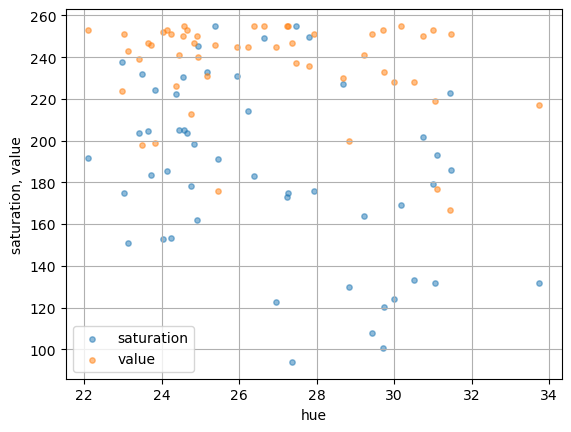

In [8]:
plt.scatter(yellow_tape_hsv_values[:, 0], yellow_tape_hsv_values[:, 1], s=15, alpha=0.5, label='saturation')
plt.scatter(yellow_tape_hsv_values[:, 0], yellow_tape_hsv_values[:, 2], s=15, alpha=0.5, label='value')
plt.grid()
plt.xlabel('hue')
plt.ylabel('saturation, value')
# plt.xlim((0, 360))
# plt.ylim((0, 255))
plt.legend()
plt.show()

..\data\test_images\floor-safety-markings-3М-767-tape-02.jpg could not be opened!


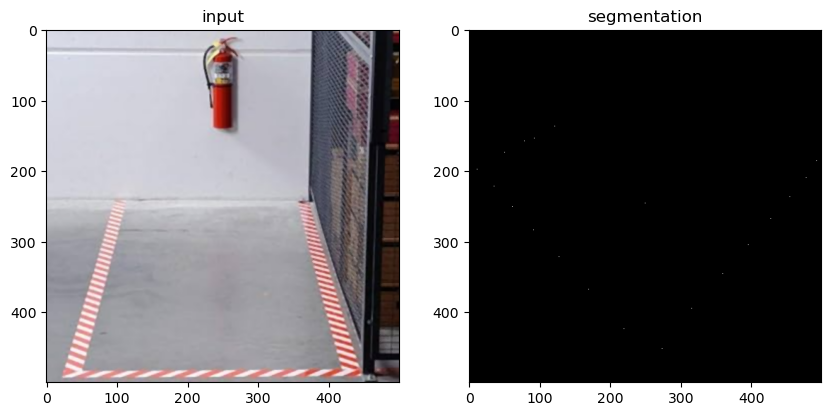

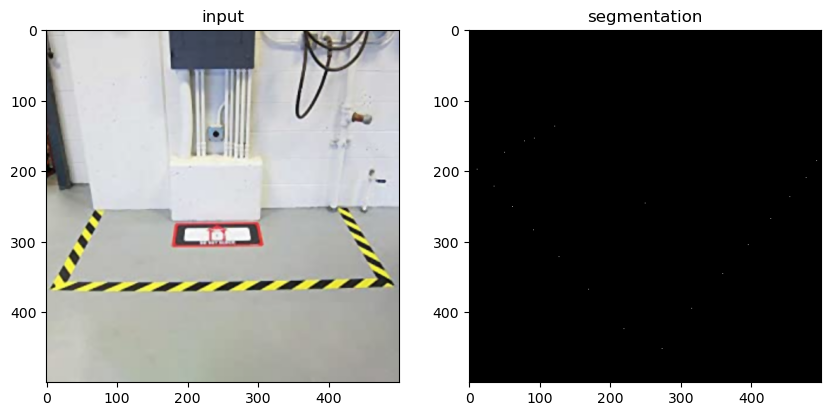

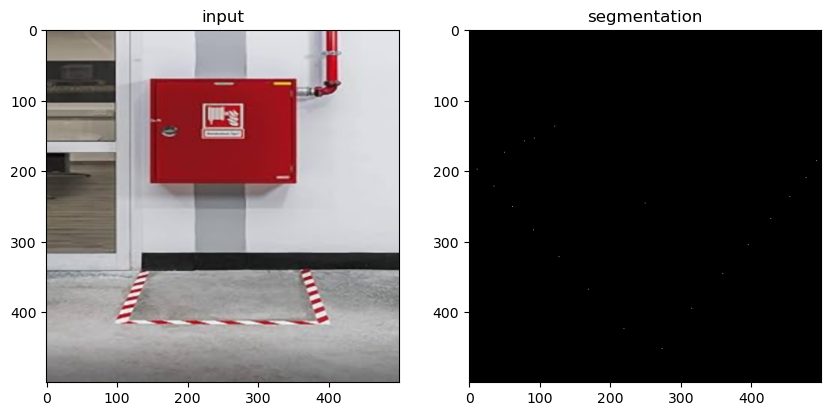

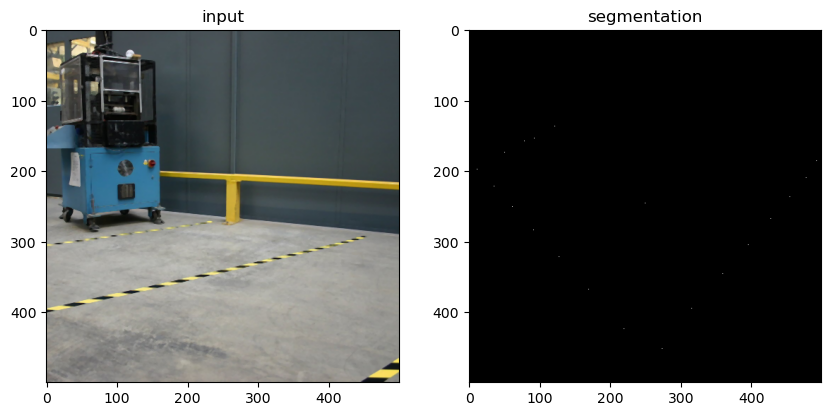

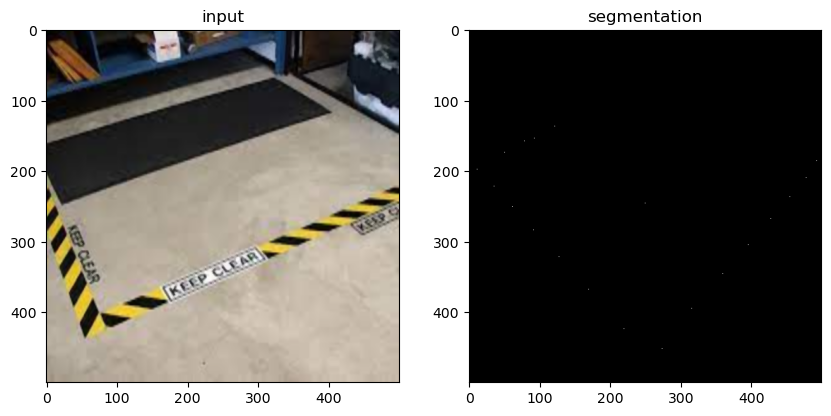

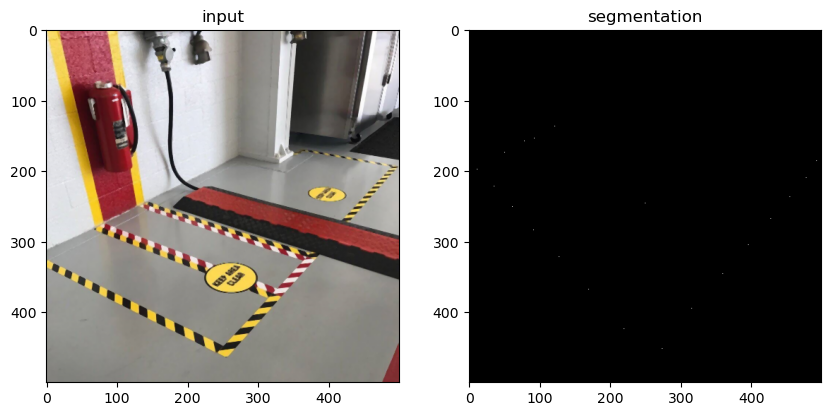

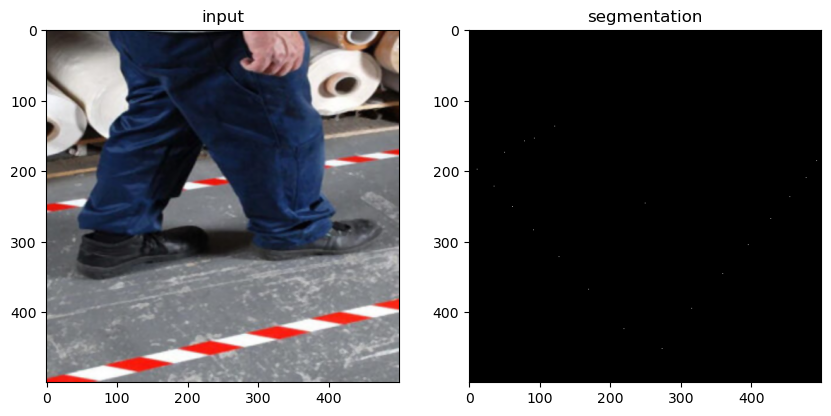

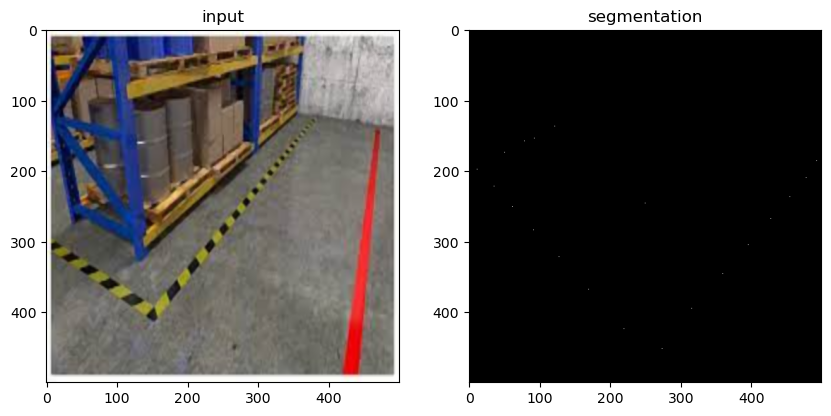

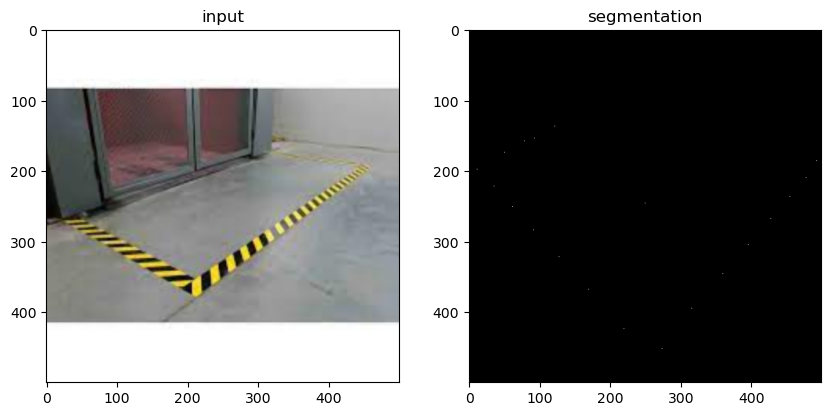

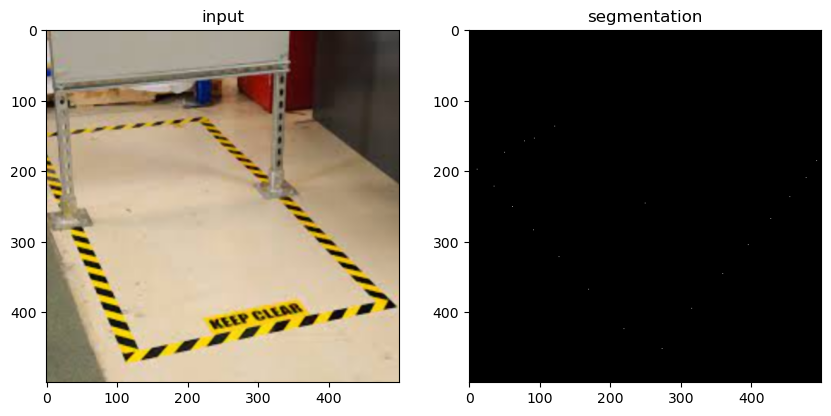

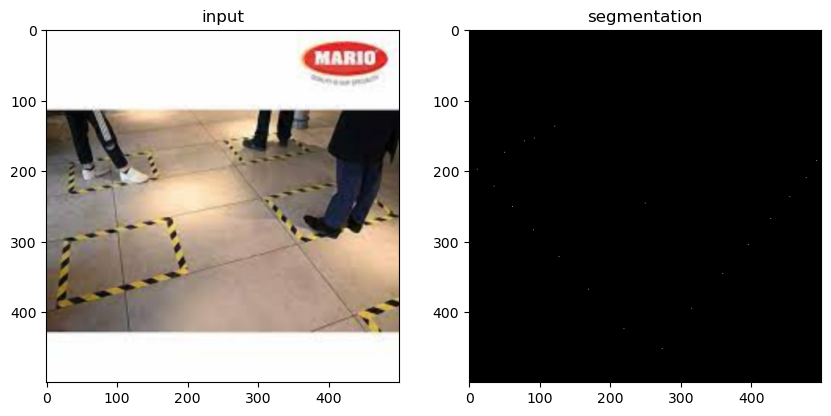

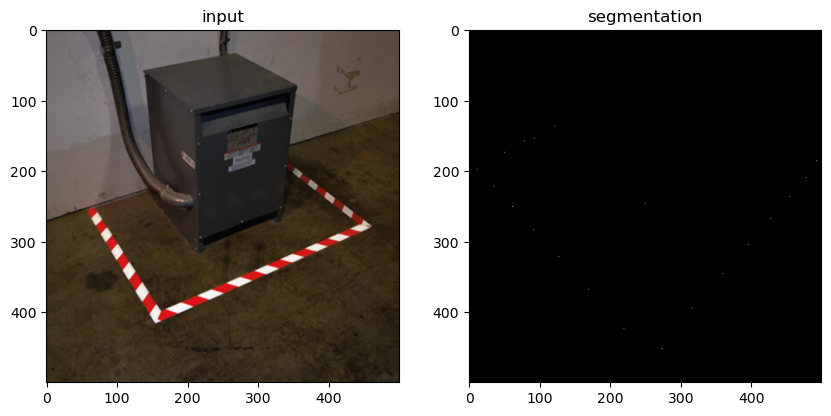

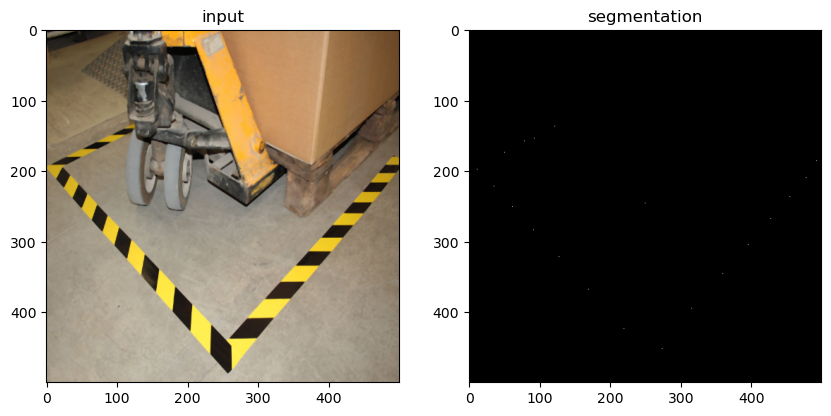

In [13]:
tape_red_min_cv2_hsv = (22, 100, 170)
tape_red_max_cv2_hsv = (32, 255, 255)


img_paths = find_files_by_ext('../data/test_images/')
for img_path in img_paths: 
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f'{str(img_path)} could not be opened!')
        continue
    img_bgr = cv2.resize(img_bgr, (500, 500))
    img_bgr = cv2.medianBlur(img_bgr, 3)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)


    mask_red = cv2.inRange(img_hsv, tape_red_min_cv2_hsv, tape_red_max_cv2_hsv)
    kernel = np.ones((3,3), np.uint8)
    mask_red = cv2.erode(mask_red, kernel, iterations=1)

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_red)
    # Create a new blank mask
    mask = np.zeros_like(mask_red)
    # Draw the centroid of each component as a single pixel
    for c in centroids:
        cx, cy = int(c[0]), int(c[1])
        mask[cy, cx] = 255

    # kernel = np.ones((3,3), np.uint8)
    # mask = cv2.dilate(mask, kernel, iterations=1)

    # Detect line segments using Probabilistic Hough Transform
    lines = cv2.HoughLinesP(mask, 1, np.deg2rad(1), threshold=6, minLineLength=80, maxLineGap=70)
    # lines = iterative_RANSAC(mask, min_samples=2, min_inliers=5, residual_threshold=2, max_trials=1000)

    # Draw line segments on the original image
    if lines is not None:
        print(f'{len(lines)=}')
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # x1, y1, x2, y2 = line
            cv2.line(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.line(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_rgb)
    axes[0].set_title('input')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('segmentation')